# Checkpoint 2: Convolutional neural networks and autoencoders
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)



In this checkpoint exercise we will use the Quick Draw dataset. 

The Quick Draw Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The bitmap dataset contains these drawings converted from vector format into 28x28 grayscale images.

We will focus on a subset of 10 classes of type "body part"

The class labels are:

![listbodypart](./list_body_parts.png)

| <p align='left'> Label                   | <p align='left'> Description| 
| ---------------------------------------- | --------------------------- |
| <p align='left'> 0                       | <p align='left'> arm        |
| <p align='left'> 1                       | <p align='left'> ear        | 
| <p align='left'> 2                       | <p align='left'> eye        |  
| <p align='left'> 3                       | <p align='left'> face      | 
| <p align='left'> 4                       | <p align='left'> foot       | 
| <p align='left'> 5                       | <p align='left'> hand       | 
| <p align='left'> 6                       | <p align='left'> knee       |
| <p align='left'> 7                       | <p align='left'> leg        |
| <p align='left'> 8                       | <p align='left'> mouth      |
| <p align='left'> 9                       | <p align='left'> nose     |


Players draw items as quickly as possible, and as you can see, some images are quite bad! We will try and train a CNN classifier to anyway see if we can train a model to distinguish the classes. We will then train an autoencoder to learn a laten space representations of the dataset.

    
This week, like last, I am not providing example notebooks like `lecture2.ipynb` and `data-science-tools.ipynb` for Unit 2, though these may still be useful to you. Instead, I am **providing the imports for all of the modules and classes that you should need.** 

### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10am on Friday 22 October 2021** 
- This CP exercise sheet is divided into **5 sections** giving a maximum of **10 marks** in total:

| <p align='left'> Title          | <p align='left'> Exercise nos. | <p align='center'> Number of marks |
| ---------------------------------------- | --------------------- | -------------------- |
| <p align='left'> 1. Visualisation and Abstraction   | <p align='left'>   1  | <p align='left'> 1.5 |
| <p align='left'> 2. Image classification | <p align='left'> 2–5  | <p align='left'> 3.5 | 
| <p align='left'> 3. Auto-encoders        | <p align='left'> 6–9  | <p align='left'> 3.0 |
| <p align='left'> 4. Anomaly detection    | <p align='left'> 10–11| <p align='left'> 2.0 |
| <p align='left'> **Total**               |                       | <p align='left'> **10** |

---
You can find the dataset for download at [this link](https://cernbox.cern.ch/index.php/s/obvLeyMR0JEEa5p).
---
---

## Preamble
---

In [1]:
# Standard import(s)
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


In [2]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras import regularizers

from tensorflow.python.keras.backend import set_image_data_format
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

## Data preprocessing (given, not marked)
---

First, we'll load in the preprocessed dataset from a numpy data file, which has already been split into training and testing parts for us.



* Each image has been **Reshaped to** $(N,N,1)$ dimension, i.e. image has one color dimention
* Images have been **Scaled** to have pixel intensities in the range [0,1]. It is an important step before feeding them to the neural network model, by dividing the values by 255. It's important that the training set and the testing set be preprocessed in the same way.
* Dataset was **Shuffled** for both training and testing datasets separately.
* Check the shapes of the resulting arrays; make sure they look as you expect.

In [3]:
#Load quickdraw bodyparts dataset
X_train, y_train, X_test, y_test = np.load('quickdraw_bodyparts.npy',allow_pickle=True) 


In [4]:
#Image labels
body_parts = ['arm', 'ear', 'eye', 'face','foot', 'hand', 'knee', 'leg', 'mouth','nose']

In [5]:
# Each label of the dataset correspond to a class name
class_names = body_parts

nb_train   = X_train.shape[0]
nb_test    = X_test.shape[0]
nb_classes = y_train.max() + 1
print("Number of training examples: {}".format(nb_train))
print("Number of testing  examples: {}".format(nb_test))
print("Number of target classes:    {}".format(nb_classes))

# Get image shape
shape = X_train.shape[1:]
print("Image shape:  {}".format(shape))

Number of training examples: 160000
Number of testing  examples: 40000
Number of target classes:    10.0
Image shape:  (28, 28, 1)


## Image visualisation and abstraction (1.5 marks)

#### 1. Display images of the training dataset, and check that the associated label makes sense (0.5 mark)

You will use `matplotlib.pyplot`, the `plt.imshow` method. Use the `cmap=plt.cm.binary` color map for all subsequent img plots.

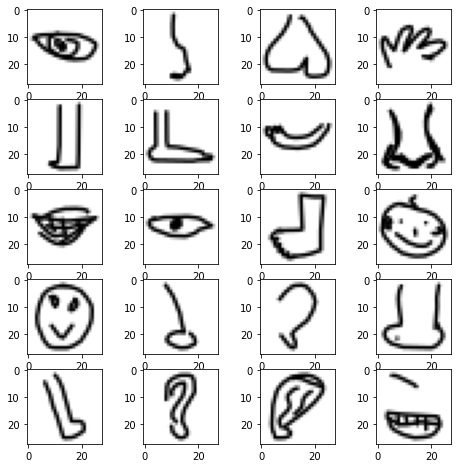

List of the images left to right, top to bottom
['eye', 'nose', 'nose', 'hand', 'leg', 'foot', 'arm', 'nose', 'mouth', 'eye', 'foot', 'face', 'face', 'nose', 'ear', 'nose', 'leg', 'ear', 'ear', 'mouth']


In [6]:

# Plotting multiple images code, showing X_train in 4 by 5 grid
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    # i-1 as subplot requires non-zero value for i
    plt.imshow(X_train[i-1], cmap=plt.cm.binary)
plt.show()

# List of the images left to right, top to bottom
partlist = []
for j in range(0, columns*rows):
    partlist.append(body_parts[int(y_train[j])])
    
    
print("List of the images left to right, top to bottom")
print(partlist)


<span style="color:blue">
Top left looks somewhat like a eye, and the first label is eye If you go through from left to right, top to bottom the labels look somewhat like the labels.
</span>    

1. plot 10 training dataset images, one per category. Label the images.

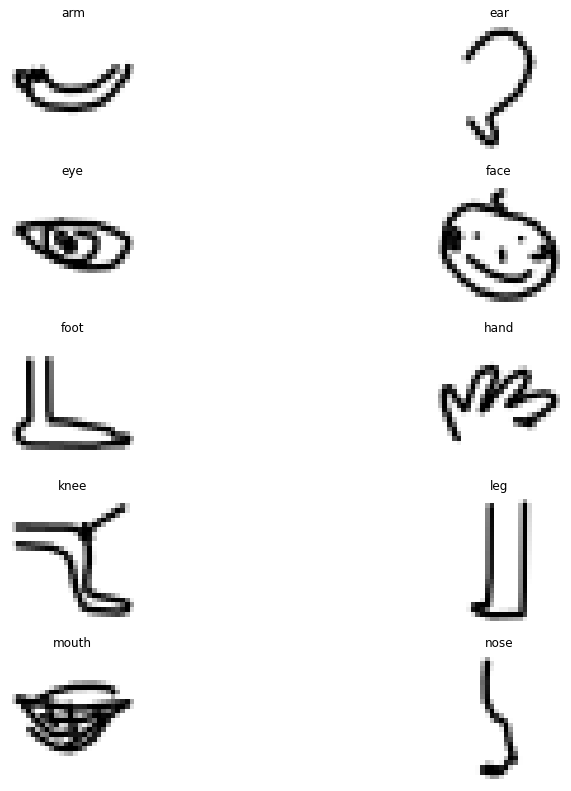

In [8]:
# Select 10 unique y_train elements
# Scan through y_train until it equals 1, then take a record of this value of 'i', reset and look for 2, up to 10.
# Not the most efficient method, but it works for this simple task.

i = 0
uniquevals = []
uniquelabels = []

while True:
    # If one of each has been found, break
    if i == 10:
        break;
    
    # Scan through y_train for 0,1,2...
    for j in range(0,len(y_train)):
        # If the value of y_train is equal to our unique label
        if (int(y_train[j]) == i):
            # Append current value of j to our list, then look for next sample and break
            uniquevals.append(j)
            i+=1
            break;
            
# Move values of y_train[j] to unique labels, and plot each specific y_train graph
for k in range(0,len(uniquevals)):
    uniquelabels.append(body_parts[int(y_train[uniquevals[k]])])
    
# Plotting
#for i in range(0, len(uniquelabels)):
#    # i-1 as subplot requires non-zero value for i
#    plt.imshow(X_train[uniquevals[i]], cmap=plt.cm.binary)
#    plt.title(uniquelabels[i])
#    plt.show()

# Plot 5x2 array of pictures
fig, axs = plt.subplots(5, 2, figsize = (14,14))

l = 0

for i in range(0,5):
    for j in range(0,2):
        axs[i,j].imshow(X_train[uniquevals[l]],cmap=plt.cm.binary)
        axs[i,j].set_title(uniquelabels[l])
        axs[i,j].axis('off')
        l+=1


<span style="color:blue">
    Labelled one per category.
</span>

2. plot the fist 25 images in a 5x5 plot. Label the images.

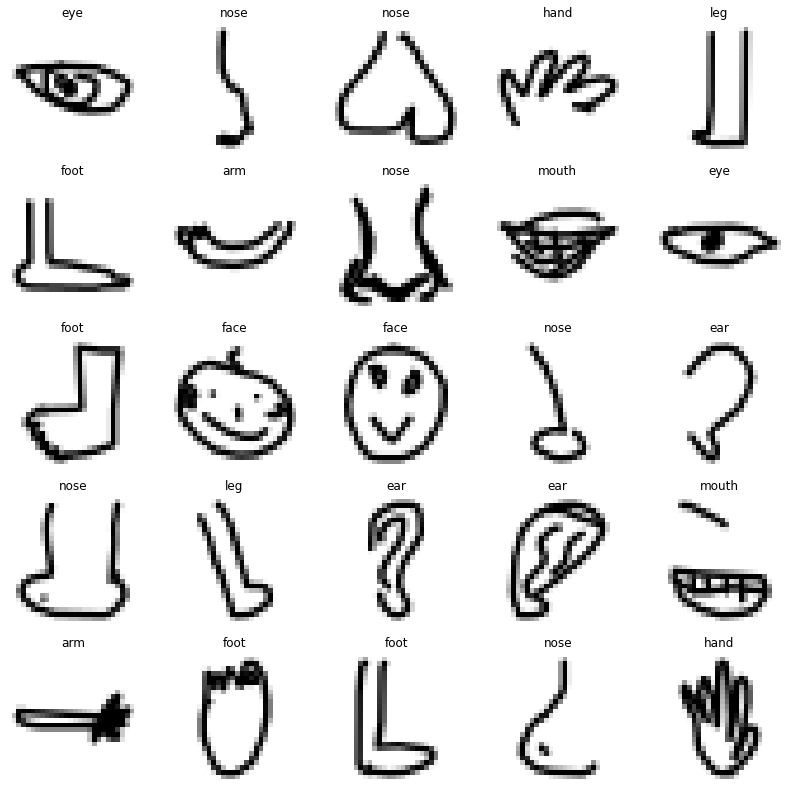

In [9]:
# Reusing earlier code:

# List of the images left to right, top to bottom
partlist = []
columns = 5
rows = 5
for j in range(0, columns*rows):
    partlist.append(body_parts[int(y_train[j])])


# Plot 5x5 array of pictures
fig, axs = plt.subplots(5, 5, figsize = (14,14))

# Used for looping
l = 0

# Loop across columns and rows, shows image, then gives said image a title
# Also removes axis', for readability
for i in range(0,columns):
    for j in range(0,rows):
        axs[i,j].imshow(X_train[l],cmap=plt.cm.binary)
        axs[i,j].set_title(partlist[l])
        axs[i,j].axis('off')
        l+=1


<span style="color:blue">
    5x5 plot of the images, with labels above
    </span>

#### 2 Apply different kernels to an image of type face (1 mark)

1. pick an image of the face type and save it to `myface`. Plot it with `imshow` (nothing fancy needed for the plot)

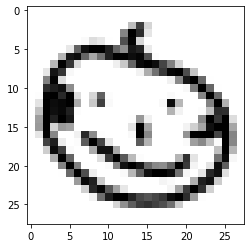

In [10]:
# Choosing a specific face
myface = X_train[11]
plt.imshow(myface,cmap=plt.cm.binary)

2. Define 4 kernels: identity, edge_detection, sharpening, and blurring, as `3x3` numpy arrays. We add them to a dictionary of kernels.

In [11]:
# Can also just write the arrays out and it will be automatically recognised
# as numpy, but I dont trust python.
k_identity = (np.array([0,0,0,0,1,0,0,0,0])).reshape((3,3))
k_edge = (np.array([-1,-1,-1,-1,8,-1,-1,-1,-1])).reshape((3,3))
k_sharp= (np.array([0,-1,0,-1,5,-1,0,-1,0])).reshape((3,3))
k_blur = np.ones((3,3))/9

# Just for proof that they're accurate, commented out
#print(k_identity)
#print(k_edge)
#print(k_sharp)
#print(k_blur)

kernels = {"identity":k_identity,"edge":k_edge,"sharp":k_sharp,"blur":k_blur}
#print(kernels)

3. Given is part of the `run_kernel` function which runs over the figure and applies the kernel to every non-edge pixel. Complete the function:
    - Define the shape of the output image `np.empty(...)`
    - Define the ranges of the row and colum loops , i.e. `range(...)`
    - Define the fig index on which the kernel is multiplied in each step, ie. `fig[....]`



In [12]:
def run_kernel(fig,kernel):
    # empty array holding the output image.
    # Removes one row and column on each side, so 28x28 goes to 26x26
    out = np.empty((26,26))
    for i in range(26):
        for j in range(26):
            # Need 3x3 from the figure, NEED TO REMEMBER LAST DIMENSION
            out[i][j] = np.sum(np.multiply(kernel,fig[i:i+3,j:j+3,0]))
                
    return out

4. run the plotting code block below and check that the kernels are doing what you expect.
    
Since some kernels multiply by negatives, we use the norm=norm(0,1) to scale the image back to between 0 and 1 before plotting. 

In [13]:
#Import the normiliser for the bitmap
from matplotlib.colors import Normalize as norm

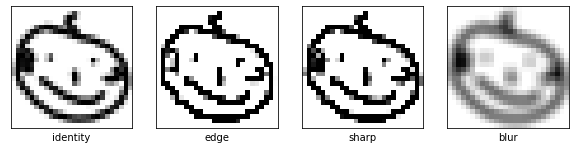

In [14]:
plt.figure(figsize=(10,10))
#Loop over kernel
for i,kernel in enumerate(kernels):
    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #return transformed image and plot it
    plt.imshow(run_kernel(myface,kernels[kernel]), cmap=plt.cm.binary,norm=norm(0,1))  
    plt.xlabel(kernel)
plt.show()



<span style="color:blue">
    Identity is a bit blurred, but is expected of the decrease in resolution. Rest are as expected.
  </span>

## Image classification (3.5 mark)
---
In this section, we will train a convolutional neural network (CNN) to perform hand-written digit recognition; a standard form of image classification. We will:
- create the model
- train the model
- evaluate its classification performance

#### 3. Define a Convolutional Neural Network suitable for image classification (1 mark).

* Use the **`Keras` functional API** to construct the model. 
* The shape of the input layer should match the shape of the prepared images.
* Add some **convolutional** and **pooling** layers in a sensible configuration. The architecture is a bit up to you, but try to reach a good level of accuracy. Around 85% on validation seems easily achievable.
    * By default, you can use $3 \times 3$ kernels, ReLU activation, and $2\times 2$ pooling; but feel free to play around with different values.
    * By default no padding is applied. You could try "same" padding in order to use the whole image, though results don't change much for me.
    * If sufferening from large overtraining 
* **Flatten** the output of the last convolutional layer.
* Connect it, to an **output** layer with the appropriate number of nodes and choice of activation function.
* Display the model architecture using the `<model>.summary()` method. Optionally display it also with the `plot_model(<model>, show_shapes=True)` method.  
* Questions:
    * _What are the number of trainable parameters in the model?_
    * _How many trainable parameters does your first convolutional layer have? Why?_
    * _Which layer has the most trainable parameters?_

In [15]:
# Create keras model

# showing that we select the shape correctly
print(X_train.shape[1:])

inpt = Input(shape=X_train.shape[1:])
conv1 = Conv2D(14, kernel_size = 3, activation = 'relu')(inpt)
pool1 = MaxPooling2D(pool_size = (2,2))(conv1)
conv2 = Conv2D(7, kernel_size = 3, activation = 'relu')(pool1)
pool2 = MaxPooling2D(pool_size = (2,2))(conv2)
flat = Flatten()(pool2)
# not mentioned in instructions, but example in lecture uses hidden layer
hidden1 = Dense(10, activation = 'relu')(flat)
output = Dense(10, activation = 'softmax')(hidden1)
kf = Model(inputs=inpt, outputs = output)

(28, 28, 1)


2021-10-21 10:36:11.441604: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# For answering the questions, using sparse_categorical crossentropy as its not
# hot encoded, but could use something else, ASK TOMORROW

# Compile
kf.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics = ["accuracy"])

# Summary of Model
kf.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 14)        140       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 14)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 7)         889       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 7)           0         
_________________________________________________________________
flatten (Flatten)            (None, 175)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1760  

* Questions:
    * _What are the number of trainable parameters in the model?_
    * _How many trainable parameters does your first convolutional layer have? Why?_
    * _Which layer has the most trainable parameters?_

<span style="color:blue">
1) According to the model, 2889.
    

2) The first convolutional layer has 140 trainable parameters. There are 14 nodes, and 10 'weights'. These 10 weights are from the 3x3 array and one extra bias variable. 10*14 = 140 parameters.

    
3) The hidden dense layer, with 1760 trainable parameters, as this is 176 nodes * 10 nodes + 10 nodes = 1760 trainable parameters.
</span>

#### 4. Compile and train the CNN image classifier (1 mark)

* Choose the appropriate loss functiton. 
* Fit for a reasonable number of epochs, use 20% of data for validation. 
* Plot the loss curve(s) by using `matplotlib.pyplot` directly with the information in the `<model>.history.history` dict.
* If you run on CPUs, stretch your legs while you wait for the 20 epoches to complete. Now is a good time for a coffee/loo break!

In [17]:
# Fit
kff = kf.fit(X_train,y_train, epochs = 20, batch_size = 32, validation_split = 0.2, shuffle = True)

2021-10-21 10:36:43.398448: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-21 10:36:43.418501: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3293770000 Hz


Epoch 1/20
4000/4000 [==============================] - 19s 5ms/step - loss: 1.1976 - accuracy: 0.6026 - val_loss: 0.7320 - val_accuracy: 0.7704
Epoch 2/20
4000/4000 [==============================] - 18s 5ms/step - loss: 0.7136 - accuracy: 0.7785 - val_loss: 0.6753 - val_accuracy: 0.7854
Epoch 3/20
4000/4000 [==============================] - 18s 5ms/step - loss: 0.6556 - accuracy: 0.7967 - val_loss: 0.6356 - val_accuracy: 0.7973
Epoch 4/20
4000/4000 [==============================] - 18s 5ms/step - loss: 0.6200 - accuracy: 0.8062 - val_loss: 0.6283 - val_accuracy: 0.8007
Epoch 5/20
4000/4000 [==============================] - 18s 5ms/step - loss: 0.5985 - accuracy: 0.8116 - val_loss: 0.5987 - val_accuracy: 0.8075
Epoch 6/20
4000/4000 [==============================] - 18s 5ms/step - loss: 0.5871 - accuracy: 0.8132 - val_loss: 0.6046 - val_accuracy: 0.8081
Epoch 7/20
4000/4000 [==============================] - 18s 5ms/step - loss: 0.5722 - accuracy: 0.8185 - val_loss: 0.5921 - val_ac

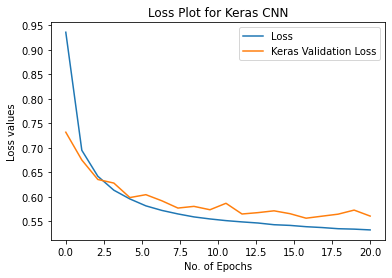

In [18]:
# Plotting the loss curve

epochs = np.linspace(0,20,20)
plt.xlabel("No. of Epochs")
plt.ylabel("Loss values")
plt.title("Loss Plot for Keras CNN")
plt.plot(epochs,kff.history['loss'], label = 'Loss')
plt.plot(epochs,kff.history['val_loss'], label = 'Keras Validation Loss')
plt.legend()
plt.show()

<span style="color:blue">
    Decent enough result, although it looks like it could use some more training! Maybe increase the epochs for better results, although overtraining may occur as the gradient decreases significantly.
    
</span>

#### 5. Evaluate the classification performance on the testing dataset (1 Mark)

* Compute the testing accuracy, _e.g._ using the `<model>.evaluate()` method. Compare to the training accuracy; can be read off from fit printout, if you added the `'accuracy'` metric, or can be calculated here.
* Display a few mis-classified images from the test dataset.
    * For this you will need to use the model to predict from the testing features.
    * This yields arrays of 10 probabilities, 1 per class. Get the index from maximum probability to find the class prediction. Maybe consider using `argmax`?
* Compute and display the confusion matrix (normalise by truth label). Discuss the results.

In [19]:
# Test accuracy
print("Test Data Accuracy & Loss")
test_acc = kf.evaluate(X_test,y_test)

print("Training Data Accuracy & Loss")
train_acc = kf.evaluate(X_train,y_train)

Test Data Accuracy & Loss
1250/1250 [==============================] - 2s 2ms/step - loss: 0.5645 - accuracy: 0.8196
Training Data Accuracy & Loss
5000/5000 [==============================] - 9s 2ms/step - loss: 0.5336 - accuracy: 0.8288


<span style="color:blue">
On the previous run, the results were approximately 0.82
   
Which are within reasonable agreement, and show that the model is relatively well trained.
    
</span>

In [21]:
# Display mis-classified images

# Calculate the probabilities for all of X_test
test_pred = kf.predict(X_test)

# So you have an array of 40000 samples, with 10 probabilities in each.
# Look through each sample for the max class probability and compare it to the true class
# If not equal then add to 'wrong prediction'

# Wrong prediction array, and its specific class value
wrong_pred = []
wrong_pred_val = []

# Loop across all samples
for i in range(len(X_test)):
    # For specific sample, find most likely class value
    max_pred = np.argmax(test_pred[i])
    # If predicted array doesn't match true array (int because its float)
    if max_pred != int(y_test[i]):
        # Add this array no to the list
        wrong_pred.append(i)
        # Adds wrong array val to the list also
        wrong_pred_val.append(max_pred)
        
print(len(wrong_pred))

    

7215


<span style="color:blue">
The number of incorrect results divided by the total data size (40000) matches with  (1 - accuracy). This makes sense and shows that the above method is correct
</span>

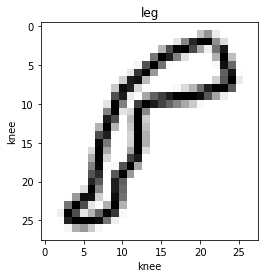

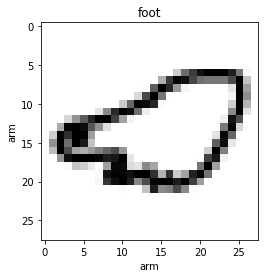

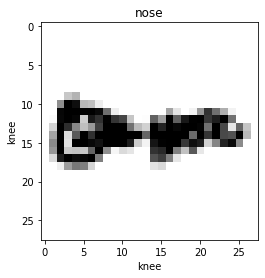

In [22]:
# Plot some incorrect guesses
for i in range(3):
    # Shows image
    plt.imshow(X_test[wrong_pred[i]],cmap=plt.cm.binary)
    # Collects its correct label
    plt.title(body_parts[int(y_test[wrong_pred[i]])])
    # What it thought it was
    plt.ylabel(body_parts[wrong_pred_val[i]])
    plt.xlabel(body_parts[wrong_pred_val[i]])
    plt.show()
    
    
# The X and Y axis are the 'incorrect labels' produced by our learning.
# The title is the correct label.

<span style="color:blue">
The X and Y axis are the 'incorrect labels' produced by our learning.
The title is the correct label.
</span>

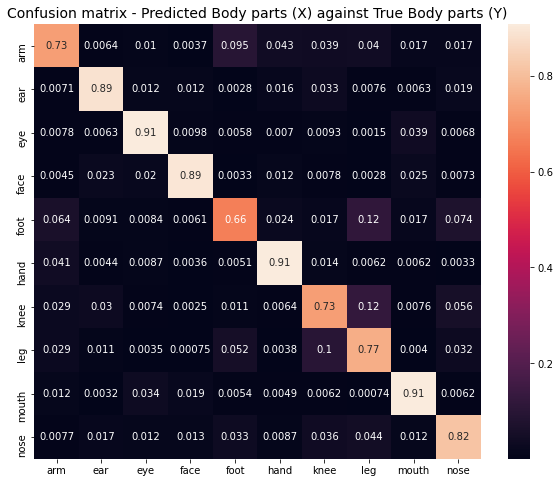

In [23]:
# Plotting confusion matrix
y_pred = np.argmax(test_pred, axis = 1)

matrix = confusion_matrix(y_test, y_pred, normalize='true')

df_cm = pd.DataFrame(matrix, index = body_parts, columns = body_parts)
plt.figure(figsize = (10,8))
plt.title('Confusion matrix - Predicted Body parts (X) against True Body parts (Y)', fontsize = 14)
sns.heatmap(df_cm, annot=True)
plt.show()

<span style="color:blue">
    The results are as expected, with the diagonal having the majority of the probability for each class, with some some confusion between knee, leg and foot (hence the 0.11 and 0.13 ). This is understandable as even in the images they are often quite similar (knees and legs, might be seen in the above plots).
</span>

For your own interest (not marked) run the first layer kernels over `myface`. You should see several copies of the image, all with varying transformations. In your training you may find different kernels, but I can clearly spot a bluring kernel in my first layer.

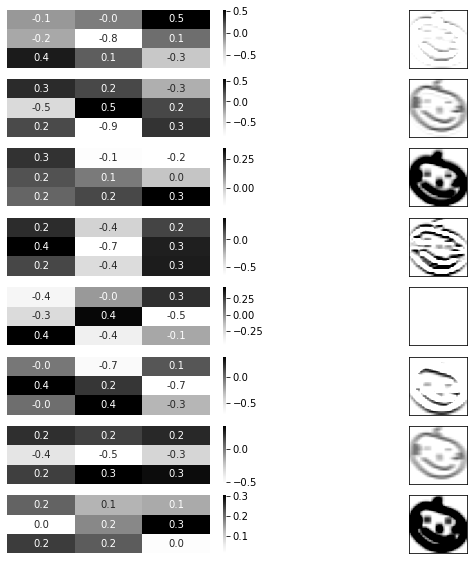

In [24]:
plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(8,2,2*(i)+1)

    sns.heatmap(kf.layers[1].get_weights()[0][:,:,:,i][:,:,0], cmap='Greys',annot=True,fmt=".1f")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.subplot(8,2,2*i+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(run_kernel(myface,kf.layers[1].get_weights()[0][:,:,:,i]),cmap=plt.cm.binary,norm=norm(0,1))
plt.show()


## Auto-encoders (3 marks)
---
In this section, we will construct and train an auto-encoder as an example of **unsupervised learning.** This type of model is made up of an **encoder** that maps an image of shape $(N,M,C)$ into a latent vector of shape $(L,)$; and a **decoder** which maps the latent vector into an image with the same shape as the original. The latent, or encoded, vector will typically be small in size compared to the input image (_i.e._ $L \ll N \times M \times C$), meaning that it is an **information bottleneck.** The aim of the auto-encoder is therefore to learn the most efficient encoding of a class of images (here: quickdraw dataset) that allows the decoder to reconstruct the original as well as possible under the bottleneck constraint.

We will break down this task into a few sub-tasks, to make it easier to get through.

#### 6. Construct the encoder (1 Marks)

* Use the `Keras` functional API to construct the encoder model. 
* The shape of the input layer should match the shape of the prepared images .
* Add some convolutional and pooling layers in a sensible configuration. 
    * Using a decreasing number of kernels for each convolutional layer (_e.g._ $16 \to 8 \to 4 \to 2 \to 1$) works quite well.
    * For this task it is worthwhile to give some thought to padding: You want to have intermediate layers with shapes that are easy to reconstruct with the decoder. As a starting point, consider using `padding='same'` for your conv. layers.
    * **See also the note below.**
    
* **Flatten** the output of the last convolutional layer, and use this as the latent vector. 
    * For convenience, we choose to make the latent vector have values in the range [0,1], so add the appropriate activation function to the preceeding convolutional layer.
* Display the model architecture using the `<model>.summary()` method, optionally also the `plot_model(<model>, show_shapes=True)` method.
    * These methods are also very useful for debugging, when you are building your network. For instance, start with the simplest possible `Keras` model; plot the architecture using one of these methods; modify the model slightly; plot the architecture again to see the effect; _etc._
    * Make sure that the output of the encoder is indeed a bottleneck, _i.e._ that the number of output nodes is significantly smaller than the number of pixels in the image. (_Hint: A latent vector could have size $49 \ll 28 \times 28 \times 1 = 784$._)
    
**Note:** Choosing the architecture for an auto-encoder can be a bit tricky. The input images we use have shape $(28,28,1)$, and when we're pooling we typically downsample by a factor of $2$. If we use "same" padding, this means that we can go down to $(7,7,F)$ with no issues. However, if we downsample further (_e.g._ $7\to 3$) it will be tricky for the decoder to reconstruct, since upsampling would result in $3\to 6$. Therefore, to keep things simple, it may be best to not downsample further than $(7,7,F)$. However, you can still add _multiple convolutional layers in a row without pooling._

In [25]:
# Constructing the encoder model
input_img = Input(shape = X_train.shape[1:])

# Encoding 
# padding on everything to preserve the image
# Using the described 16 -> 8 -> 4 -> 2 -> 1 convolutional layer method.

enc_conv1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(input_img)
enc_pool1 = MaxPooling2D((2,2), padding = 'same')(enc_conv1)
enc_conv2 = Conv2D(8, (3,3), activation = 'relu', padding = 'same')(enc_pool1)
enc_conv3 = Conv2D(4, (3,3), activation = 'relu', padding = 'same')(enc_conv2)
enc_pool2 = MaxPooling2D((2,2), padding = 'same')(enc_conv3)
enc_conv4 = Conv2D(2, (3,3), activation = 'relu', padding = 'same')(enc_pool2)
enc_conv5 = Conv2D(1, (3,3), activation = 'sigmoid', padding = 'same')(enc_conv4)
# sigmoid to make latent vector (0,1)
flatent = Flatten()(enc_conv5)

# Model
encoder = Model(input_img, flatent)




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 4)         292       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 2)           74  

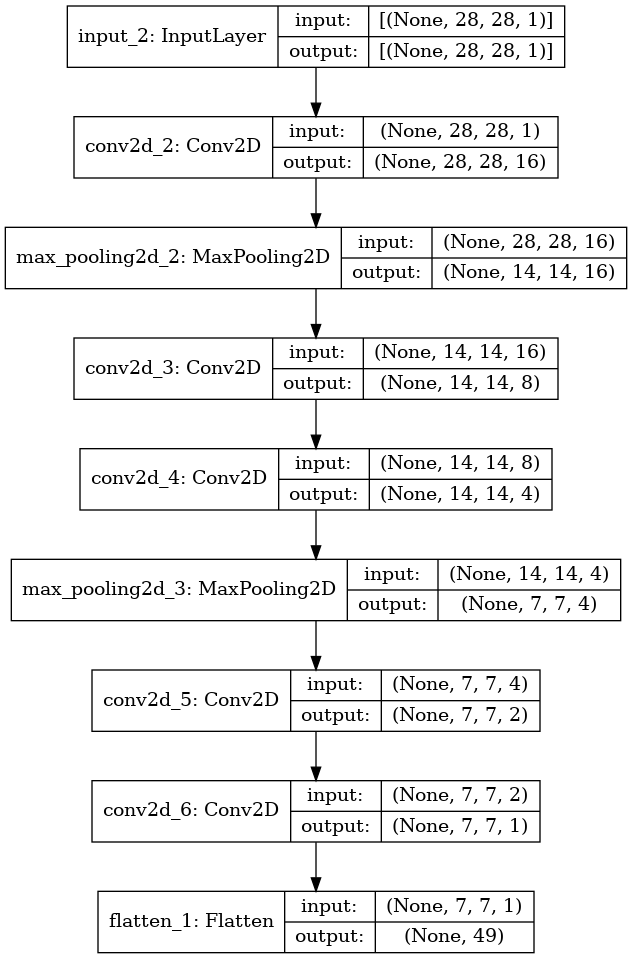

In [26]:
# Summary and model
encoder.summary()
plot_model(encoder,show_shapes = True)

<span style="color:blue">
    Output shape of 49, which is less than 28 x 28 x 1. This is clearly the bottleneck in our system.
</span>

#### 7. Construct the decoder (1 Mark)

* Use the `Keras` functional API to construct the decoder model. 
* **Reshape** the latent vector to have the shape of the last convolutional layer in the encoder.
* The shape of the input layer should match the shape of the latent vector.
* Add some convolutional and **upsampling** layers in a sensible configuration. 
    * You can use the same order of kernels (_e.g._ $16 \to 8 \to 4 \to 2 \to 1$) as in the encoder.
    * Many of the notes and considerations mentioned for the encoder hold for the decoder as well.
* The output of the decoder should have the same shape as the number images. Also, choose an output activation that is appropriate to the dataset.
* Display the model architecture using the `<model>.summary()` method, optionally also the `plot_model(<model>, show_shapes=True)` method.
    * As for the encoder, these methods can be very useful for debugging.

In [27]:
# Constructing the decoder

# Reshape the input to (14,14,1), which will have the latent vector inserted into it.
# Padding on the convolutional layers
flatinput = Input(shape = (49))
unflatent = Reshape((7,7,1))(flatinput)
dec_conv1 = Conv2D(2, (3,3), activation = 'relu', padding = 'same')(unflatent)
dec_conv2 = Conv2D(4, (3,3), activation='relu', padding = 'same')(dec_conv1)
dec_upsample1 = UpSampling2D((2,2))(dec_conv2)
dec_conv3 = Conv2D(8, (3, 3), activation='relu', padding = 'same')(dec_upsample1)
dec_conv4 = Conv2D(16, (3, 3), activation='relu', padding = 'same')(dec_conv3)
dec_upsample2 = UpSampling2D((2,2))(dec_conv4)
# Sigmoid to give (0,1) results
dec_output = Conv2D(1, (3, 3), activation='sigmoid', padding = 'same')(dec_upsample2)

decoder = Model(flatinput, dec_output)




Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 1)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 2)           20        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 4)           76        
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 8)         296       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 16)        1168

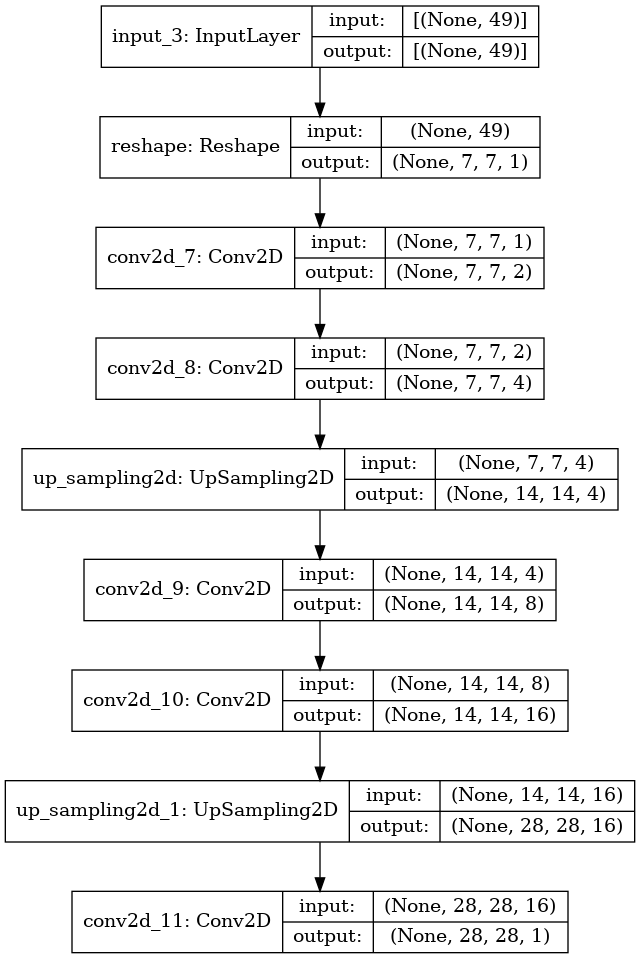

In [28]:
# Summary and model
decoder.summary()
plot_model(decoder,show_shapes = True)

<span style="color:blue">
    So you get the expected shape out at the end, which is what you want!
</span>

#### 8. Construct the auto-encoder (given, not marked)

Connecting the encoder and decoder to form the auto-encoder is a slightly tricky use of the `Keras` functional API, so I'll just give that to you. Assuming you have given you encoder and decoder intuitive names, the following should do the trick:

In [29]:
i   = encoder.input
cae = Model(i, decoder(encoder(i)), name='ConvAE')
cae.summary()

Model: "ConvAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_1 (Functional)         (None, 49)                1705      
_________________________________________________________________
model_2 (Functional)         (None, 28, 28, 1)         1705      
Total params: 3,410
Trainable params: 3,410
Non-trainable params: 0
_________________________________________________________________


Try to make sure that you understand what is going on here: In the `Keras` functional API, layers and even entire models work like functions (thus the name). What we're doing above is passing an input image `i` through the encoder (resulting in a latent vector); passing the output of `encoder` as the input to `decoder` (resulting in a reconstructed image); and finally using the output of `decoder` as the output of the auto-encoder.

#### 9. Compile and train the auto-encoder (1 Mark)

* Choose an appropriate loss function.
* Train for ca. 10 epochs with some data held out for validation. Time for another coffee break!
* Plot the loss curve(s).
* Perform the auto-encoding for the testing images (use the `<model>.predict()` method) and display the first couple of _(a)_ original and _(b)_ auto-encoded images to see whether the outputs resembles the original images.

In [30]:
# Compile
cae.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ["accuracy"])

# Fit. Unsupervised so uses X_train against X_train.
caefit = cae.fit(X_train,X_train, epochs = 10, batch_size = 32, validation_split = 0.2, shuffle = True)

Epoch 1/10
4000/4000 [==============================] - 52s 13ms/step - loss: 0.2571 - accuracy: 0.7610 - val_loss: 0.1717 - val_accuracy: 0.7776
Epoch 2/10
4000/4000 [==============================] - 52s 13ms/step - loss: 0.1693 - accuracy: 0.7782 - val_loss: 0.1647 - val_accuracy: 0.7790
Epoch 3/10
4000/4000 [==============================] - 52s 13ms/step - loss: 0.1639 - accuracy: 0.7791 - val_loss: 0.1618 - val_accuracy: 0.7791
Epoch 4/10
4000/4000 [==============================] - 52s 13ms/step - loss: 0.1614 - accuracy: 0.7794 - val_loss: 0.1604 - val_accuracy: 0.7799
Epoch 5/10
4000/4000 [==============================] - 52s 13ms/step - loss: 0.1592 - accuracy: 0.7801 - val_loss: 0.1593 - val_accuracy: 0.7796
Epoch 6/10
4000/4000 [==============================] - 52s 13ms/step - loss: 0.1582 - accuracy: 0.7800 - val_loss: 0.1570 - val_accuracy: 0.7802
Epoch 7/10
4000/4000 [==============================] - 52s 13ms/step - loss: 0.1574 - accuracy: 0.7800 - val_loss: 0.1561 -

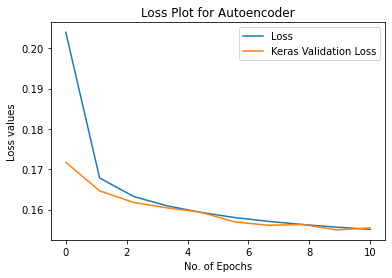

In [31]:
# Plotting the loss curve

epochs = np.linspace(0,10,10)
plt.xlabel("No. of Epochs")
plt.ylabel("Loss values")
plt.title("Loss Plot for Autoencoder")
plt.plot(epochs,caefit.history['loss'], label = 'Loss')
plt.plot(epochs,caefit.history['val_loss'], label = 'Keras Validation Loss')
plt.legend()
plt.show()

In [32]:
# Auto encoding of the test images using model predict.
image_pred = cae.predict(X_test)

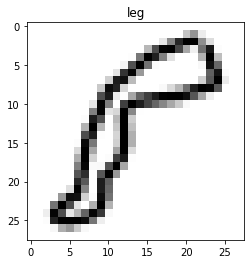

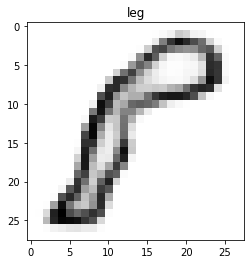

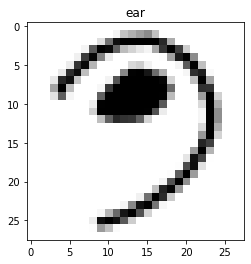

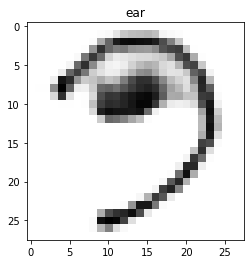

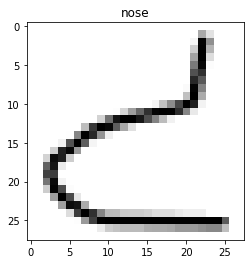

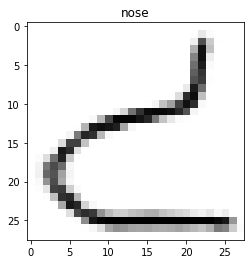

In [33]:
# Plot predictions
for i in range(3):
    # Shows true image
    plt.imshow(X_test[i],cmap=plt.cm.binary)
    # Collects its correct label
    plt.title(body_parts[int(y_test[i])])
    plt.show()
    
    # Show reproduced image
    plt.imshow(image_pred[i], cmap=plt.cm.binary)
    plt.title(body_parts[int(y_test[i])])
    plt.show()

<span style="color:blue">
    The first graph is the true image for each type, the second image is the recreated image. This is copied three times with the type listed at the top. These results (at least for my run) gives relatively good results. It recreates some of the images very closely.
</span>

#### 10. Plot images in the laten space (NOT MARKED)
- Predict 10 images into the laten space using the encoder only.
- Reshape the output to images and plot the laten space images. e.g. if your encoder outputs 49 features, make 7x7 image

In [34]:
# I dont have time :(

## Anomaly detection (2 marks)
---

We have introduced auto-encoders as a form of unsupervised learning, since we are not using the image labels during training. This means that auto-encoders are not ideal for image classification (at least not since we actually _have_ the labels), but they can be used for something else: anomaly detection. This is the task of identifying examples that the model considers "anomalous" with respect to the dataset used during training. 

First, we'll load in some "anomalous" data:

In [35]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces(shuffle=True)['images']
faces = faces[:,4:-4:2,4:-4:2,np.newaxis]

#### 9. Inspect the face images and the auto-encoder result (1 mark)

* How many samples does the "outlier" dataset (_i.e._ `faces`) contain?
* What is the shape of the images and what is the range of pixel intensities? Does this conform with the preprocessed quickdraw images?
* Display the first few face images.
* Get the output/prediction of the auto-encoder from the previous section when applied to all of the faces.
* Show the auto-encoded versions of the same faces you showed above. Discuss the results.

In [36]:
# 400 Faces!
print(len(faces))

400


Image shape:  (28, 28, 1)
Image Maximum and Minimum Intensities:  0.021, 0.971


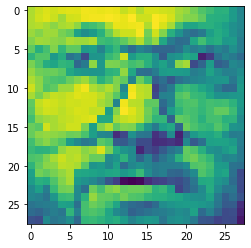

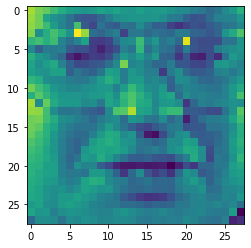

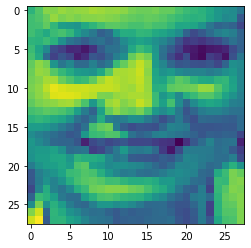

In [37]:
# Get image shape
shapes = faces.shape[1:]
print("Image shape:  {}".format(shapes))
# Find max and minimum intensities in an image
print("Image Maximum and Minimum Intensities:  {:.3f}, {:.3f}".format(faces.min(), faces.max()))

# Plot some faces
for i in range(3):
    plt.imshow(faces[i])
    plt.show()


<span style="color:blue">
    These are unlike the initial quickdraw images, as all pixels are involved in the producing the image. The quickdraw images are just a drawing and then white space.
</span>

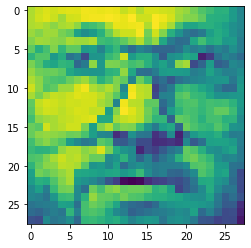

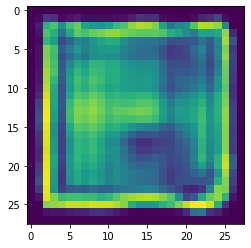

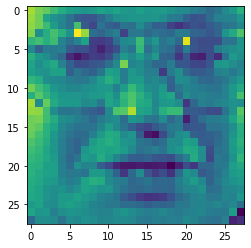

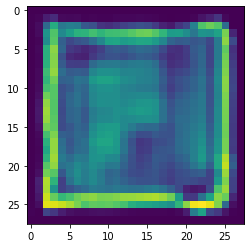

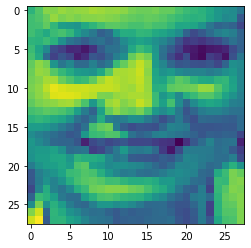

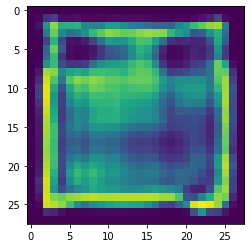

In [38]:
# Apply predict to these faces.
# Auto encoding of the test images using model predict.
image_pred_face = cae.predict(faces)

# Plot faces and their predicted versions
# Plot some incorrect guesses
for i in range(3):
    # Shows true image
    plt.imshow(faces[i])
    plt.show()
    
    # Show reproduced image
    plt.imshow(image_pred_face[i])
    plt.show()

<span style="color:blue">
    While the images are a valid shape for our autoencoder, the contents of which it was trained upon is nothing like these new images (no similar characteristics between bad drawings of body parts and real life faces). This means the predictions are wildly inaccurate when compared to the initial images, as the auto-encoder is trained to learn poorly drawn body parts, rather than faces. We could say that to the auto-encoder, these faces are anomalies as they are not like any of the images it was initially trained upon, and so it can't encode them particularly well.
</span>

#### 11. Perform anomaly detection (1 mark)
Imagine now that we had a dataset comprised of mostly quickdraw images, but also a small subset of anomalies or "outliers"; here, in the form of black-and-white images of faceses, with the same shape as the quickdraw images.

In [39]:
# Combined MNIST images and "outliers" in a mixed dataset
mixed = np.vstack((X_test, faces))

# Shuffle the mixed dataset so the "outliers" are randomly distributed
indices = np.random.permutation(mixed.shape[0])
mixed   = mixed[indices]

The auto-encoder was trained to minimise the difference between the original and the auto-encoded image, so let's use binary cross-entropy (BCE) as our metric for the difference between an image and its auto-encoded version. The `binary_crossentropy` method provided below computes **pixel-wise BCE** for two (arrays of) images: the input and the output image.

In [40]:
def binary_crossentropy (img_in, img_out):
    assert img_in.shape == img_out.shape
    eps = np.finfo(float).eps
    img_out = np.clip(img_out, eps, 1. - eps)
    return - (img_in * np.log(img_out) + (1 - img_in) * np.log(1 - img_out))

---
* Define a new method called `difference` which takes as input two arrays of images (`img_in` and `img_out`; similar to the `binary_crossentropy`); computes the **average BCE value for each image,** or row; and returns a vector of these difference measures.
* For each image, or row, in `mixed`, compute the difference score of the auto-encoded image wrt. the original image. This is a measure of how "inlier"- or "outlier"-like an image is.
* Make a histogram of these scores, and see if you can identify any structure. It might be useful to use a logarithmic x-axis (see `plt.xscale`) along with logarithmic x-axis bins (see `np.logspace`).
* Show the 9 least and the 9 most outlying images, according to this difference score. Discuss the results.

In [41]:
def difference(img_in, img_out):
    # take image in and image out and find the average BCE value for each image.
    # Then return a vector of these difference measures
    BCE_av = []
    # Loop binary_crossentropy for each image
    for i in range(len(img_in)):
        bce = binary_crossentropy(img_in[i],img_out[i])
        # average each image to get an average BCE
        BCE_av.append(np.mean(bce))
    # Returns array of average BCE's per image
    return BCE_av
        
    


In [42]:
# Encoding the mixed table
mixed_pred = cae.predict(mixed)

# calculate difference between prediction and true images
diff = difference(mixed, mixed_pred)



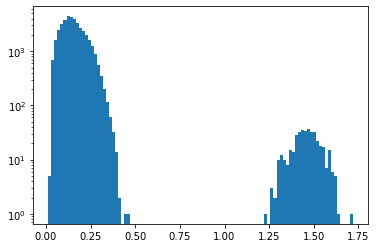

In [43]:
# Plot
plt.hist(diff, bins = 100)
plt.yscale('log')
plt.show()

<span style="color:blue">
    The outliers are clearly in the 1.25 to 1.75 section, as they have the largest difference from initial to final results.
</span>

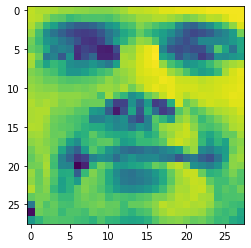

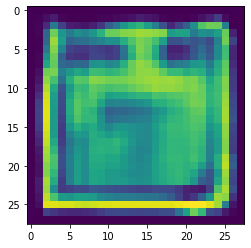

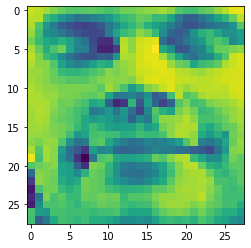

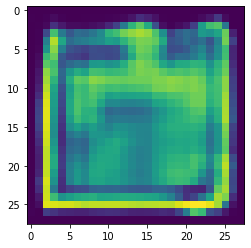

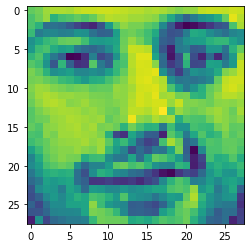

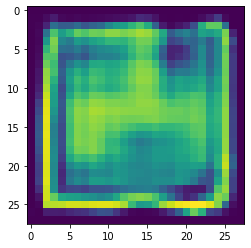

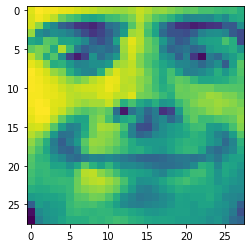

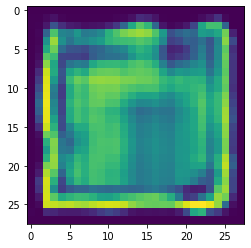

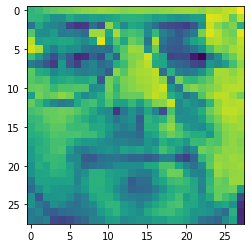

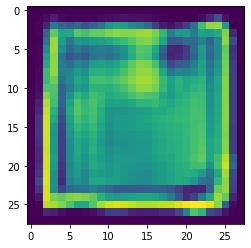

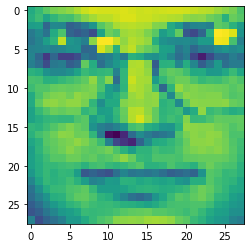

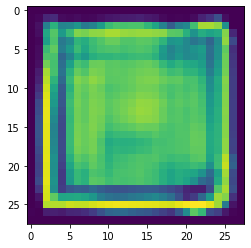

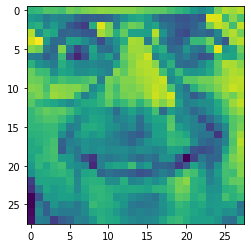

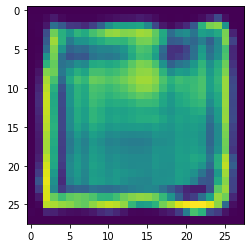

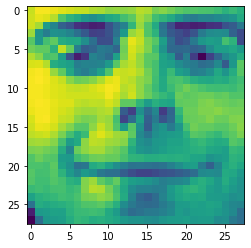

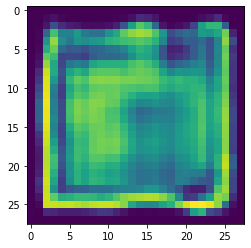

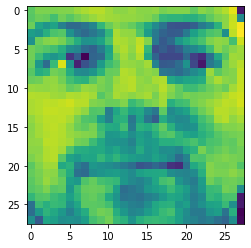

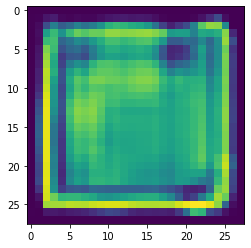

In [44]:
arr = np.array(diff)
# Take top 9 values of diff
arra = arr.argsort()[-9:][::-1]

# Plot the 9 maximum difference value plots
for i in range(len(arra)):
    # Plots the face then the prediction
    plt.imshow(mixed[arra[i]])
    plt.show()
    plt.imshow(mixed_pred[arra[i]])
    plt.show()

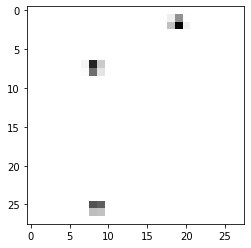

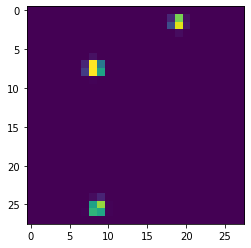

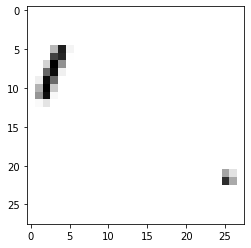

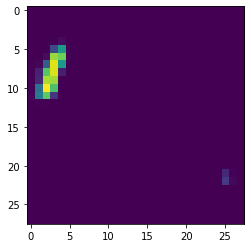

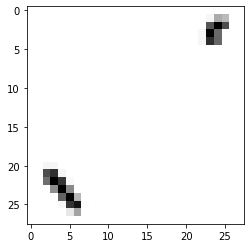

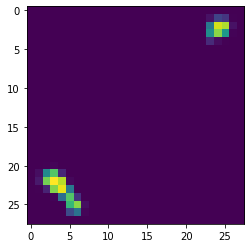

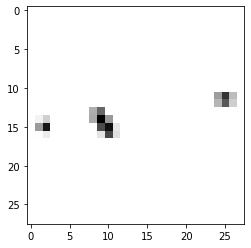

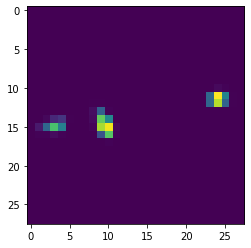

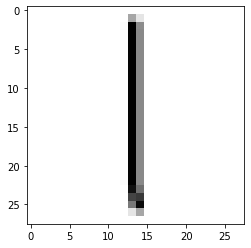

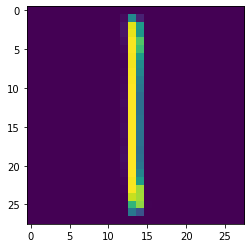

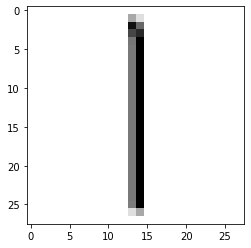

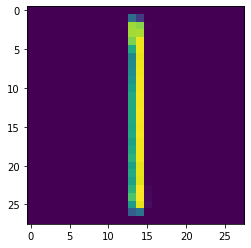

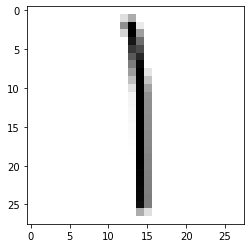

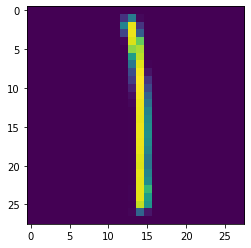

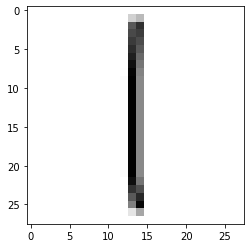

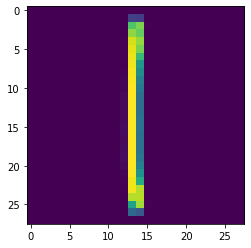

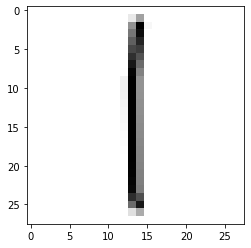

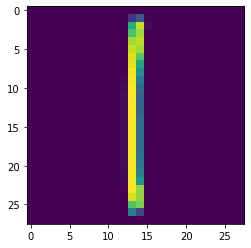

In [45]:
# Take bottom 9 values of diff by flipping the diff array
narr = -np.array(diff)
# Argsort is always largest first, so now that its flipped, the smallest values become the largest.
narra = narr.argsort()[-9:][::-1]


# Plot the 9 minimum difference value plots
for i in range(len(narra)):
    # Plots the original and then the recreation. Because they're so similar I'm leaving the recreations in colour
    plt.imshow(mixed[narra[i]], cmap=plt.cm.binary)
    plt.show()
    plt.imshow(mixed_pred[narra[i]])
    plt.show()

<span style="color:blue">
    As we can see, the top 9 largest difference results are the faces which is what we expect. They're recreations look nothing like the original images because the encoder isn't trained to deal with them. The bottom 9 difference results are images of just lines and dots, which are very simple shapes that our auto-encoder is very good at recreating.
</span>

In [46]:
print("The largest and smallest differences:  {:.3f}, {:.3f}".format(diff[narra[0]], diff[arra[0]]))


The largest and smallest differences:  0.013, 1.717
